# Large area utilities

Many times we would like to run algorithms for large geographical areas. However due to large amount of data we probably won't have enough working memory to do that all at once. So we need to split the area into smaller parts and properly manage them. To make this easier `sentinelhub` package implements utilities for splitting areas into smaller bounding boxes.

## Prerequisites

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString

from sentinelhub import BBoxSplitter, OsmSplitter, TileSplitter, read_data, CRS, DataSource, transform_bbox

The following packages are not included or required for `sentinelhub` package however they are used in this example notebook. In case you would like to reproduce some visualizations you will have to install them separately.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon

from mpl_toolkits.basemap import Basemap  # Avaliable here: https://github.com/matplotlib/basemap

### Collecting data

For start we need a geometry of the area of interest. The `sentinelhub` package uses `shapely` package to work with geometries. Therefore any geometry inputs need to be an instance of `shapely.geometry.multipolygon.MultiPolygon` or `shapely.geometry.polygon.Polygon`.

In these examples we will use a geometry of [Hawaii islands](https://en.wikipedia.org/wiki/Hawaiian_Islands).

In [4]:
INPUT_FILE = './data/Hawaii.json'

geo_json = read_data(INPUT_FILE)
hawaii_area = shape(geo_json["features"][0]["geometry"])

type(hawaii_area)

shapely.geometry.multipolygon.MultiPolygon

Let's check how the area looks on the world map.

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


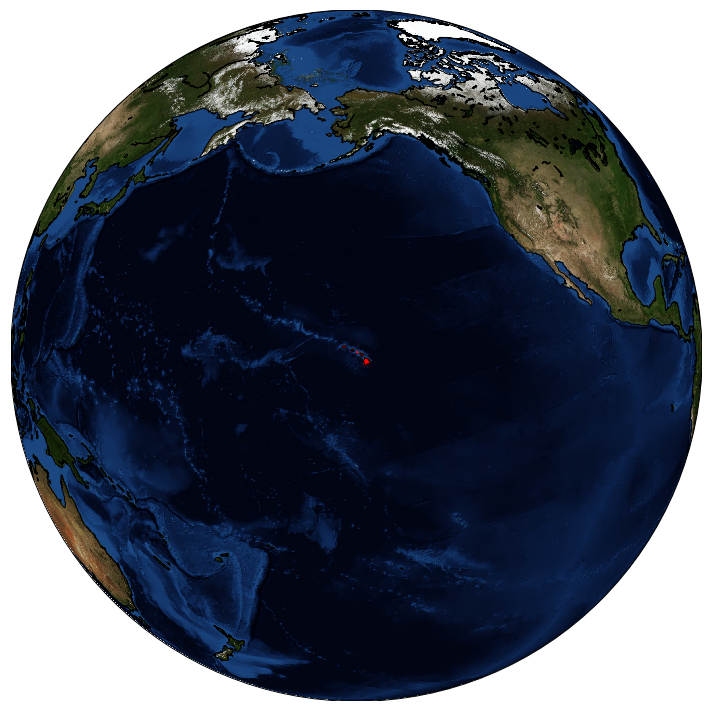

In [5]:
def show_area(area_shape, area_buffer=0.3):
    fig=plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2
    
    m = Basemap(projection='ortho',lat_0=lat, lon_0=lng, resolution='l')
    m.drawcoastlines()
    m.bluemarble()
    
    if isinstance(area_shape, Polygon):
        area_shape = [area_shape]
    for polygon in area_shape:
        x, y = np.array(polygon.boundary)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor='red', edgecolor='red'))

    plt.tight_layout()
    plt.show()

show_area(hawaii_area)

## Area Splitting

We would like to split the area into smaller bounding boxes which could them be used for obtaining data by calling WMS/WCS requests. The package implements 3 different ways of splitting the area.

### Splitting the bounding box

The most straight forward approach is to calculate the area bounding box and split it into smaller parts of equal size.

As an input we need to provide a list of geometries, their CRS, and `int` or `tuple` specifying to how many parts bounding box will be split. 

In [6]:
bbox_splitter = BBoxSplitter([hawaii_area], CRS.WGS84, (5, 4))  # bounding box will be split into grid of 5x4 bounding boxes

print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created.\nExample:\n'
      'bbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Area bounding box: BBox(((-159.764448, 18.948267), (-154.807817, 22.228955)), crs=EPSG:4326)

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-159.764448, 21.408783), (-158.77312179999998, 22.228955)), crs=EPSG:4326)
info: {'index_y': 3, 'index_x': 0, 'parent_bbox': BBox(((-159.764448, 18.948267), (-154.807817, 22.228955)), crs=EPSG:4326)}



Besides the list of bounding boxes it is also possible to get a list of geometries (i.e. intersection of each bounding box with entire area of interest).

[<shapely.geometry.polygon.Polygon object at 0x7f1b20c3f550>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f5c0>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f5f8>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f630>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f668>, <shapely.geometry.multipolygon.MultiPolygon object at 0x7f1b20c3f6a0>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f6d8>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f710>, <shapely.geometry.polygon.Polygon object at 0x7f1b20c3f748>]


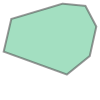

In [7]:
geometry_list = bbox_splitter.get_geometry_list()

print(geometry_list)
geometry_list[0]

In order to visualize the splits let's use the following function

In [8]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.get_middle()
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h
    
    fig=plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
     
    base_map = Basemap(projection='mill', lat_0=lat, lon_0=lng, llcrnrlon=minx, llcrnrlat=miny,
                       urcrnrlon=maxx, urcrnrlat=maxy, resolution='l', epsg=4326)
    base_map.drawcoastlines(color=(0, 0, 0, 0))
    
    area_shape = splitter.get_area_shape()
    if isinstance(area_shape, Polygon):
        area_shape = [area_shape]
    for polygon in area_shape:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))
        else:
            ax.add_patch(plt_polygon(np.array(polygon.boundary), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))
    
    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()
    
    cm = plt.get_cmap('jet', len(bbox_list))
    legend_shapes = []
    for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
        wgs84_bbox = transform_bbox(bbox, CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor='green'))
        
        if show_legend:
            legend_shapes.append(plt.Rectangle((0,0),1,1, fc=cm(i)))
    
    if show_legend:
        plt.legend(legend_shapes, ['{},{}'.format(info['index_x'], info['index_y']) for info in info_list])
    plt.tight_layout()
    plt.show()

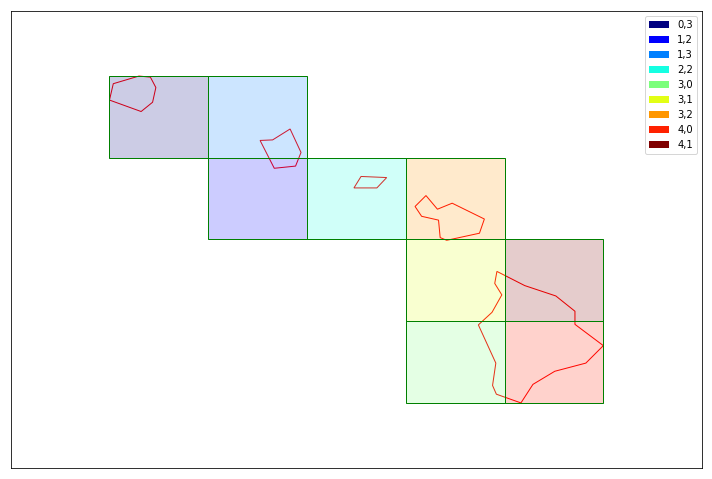

In [9]:
show_splitter(bbox_splitter, show_legend=True)

Splitter automatically removed the bounding boxes that did not intersect with the geometry of Hawaii Islands. However the majority of the area inside bounding boxes is still outside our geometry. Therefore each splitter has also an optional parameter `reduce_bbox_sizes`.

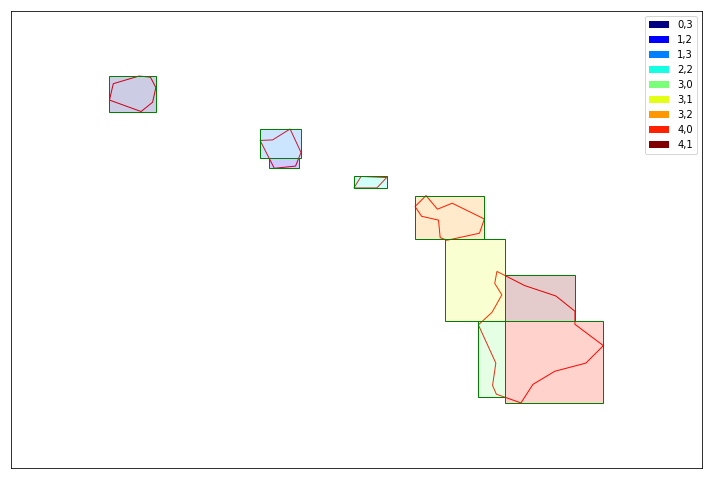

In [10]:
bbox_splitter_reduced = BBoxSplitter([hawaii_area], CRS.WGS84, (5, 4), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

By specifying finer splitting we could even further reduce the total area of bounding boxes.

### Splitting in OSM grid

Sometimes it is better to have a splitting grid independent from the given geometries. That way if the geometries at some point slightly change the grid will stay the same.

The following splitter implements [Open Street Map's grid](https://wiki.openstreetmap.org/wiki/Slippy_Map).

In [11]:
osm_splitter = OsmSplitter([hawaii_area], CRS.WGS84, zoom_level=10)

print(osm_splitter.get_bbox_list()[0].__repr__())
print(osm_splitter.get_info_list()[0])

BBox(((-159.96093749999997, 21.616579336740593), (-159.609375, 21.943045533438166)), crs=EPSG:4326)
{'index_y': 448, 'index_x': 57, 'zoom_level': 10}


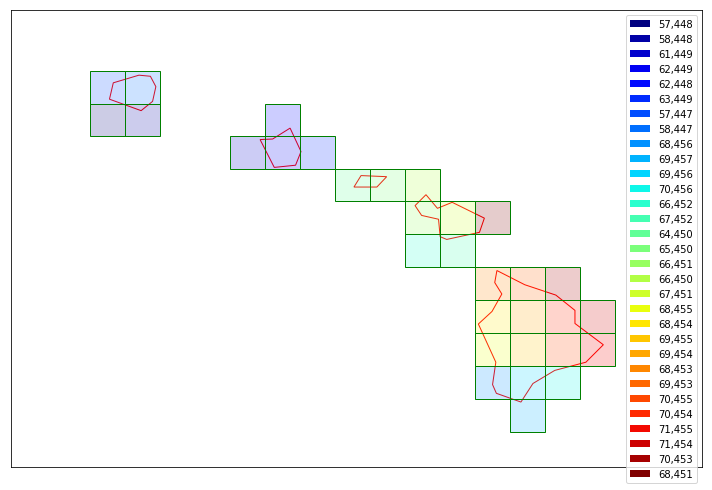

In [12]:
show_splitter(osm_splitter, show_legend=True)

### Splitting in satellite's tile grid

If we would like to work on a level of satellite tiles and split them we can use the `TileSplitter`. It works in combination with Sentinel Hub WFS service therefore an instance ID is required. We also need to specify `time_interval` and `data_source`.

In [13]:
INSTANCE_ID = ''  # Insert your instance ID here or into the configuration file

tile_splitter = TileSplitter([hawaii_area], CRS.WGS84, ('2017-10-01', '2018-03-01'),
                             data_source=DataSource.SENTINEL2_L1C, instance_id=INSTANCE_ID)

tile_bbox_list = tile_splitter.get_bbox_list()

print(len(tile_bbox_list))
print(tile_bbox_list[0].__repr__())
print(tile_splitter.get_info_list()[0])

16
BBox(((699960.0, 2190240.0), (809760.0, 2300040.0)), crs=EPSG:32604)
{'tile': '4QGH', 'index_y': 0, 'index_x': 0, 'parent_bbox': BBox(((699960.0, 2190240.0), (809760.0, 2300040.0)), crs=EPSG:32604)}


`TileSplitter` by default returns bounding boxes in the satellite tile CRS. In order to transform them we can use `transform_bbox(bbox, target_crs)` function or by specifying `crs` parameter in `get_bbox_list` method.

Note: This will only transform bounding box vertices and therefore the new bounding box will not be completely aligned with the original one. 

In [14]:
tile_splitter.get_bbox_list(crs=CRS.WGS84)[0]

BBox(((-157.0911313638967, 19.797848807227947), (-156.02495394737005, 20.77445045179882)), crs=EPSG:4326)

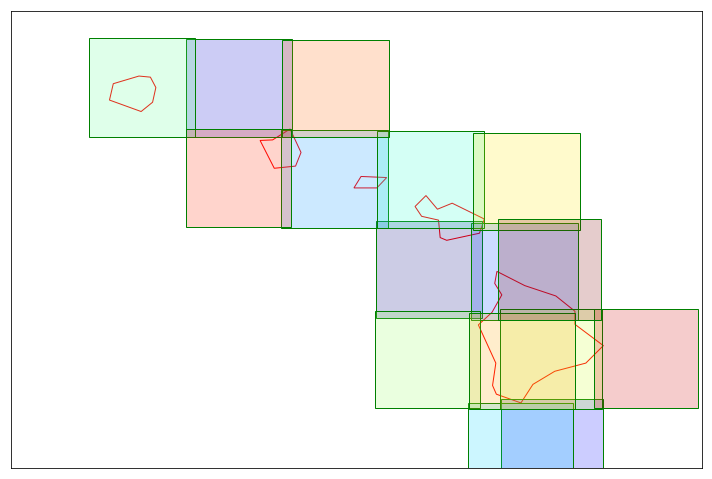

In [15]:
show_splitter(tile_splitter, show_legend=False)

Obtained Sentinel-2 tiles intersect each other. Therefore this splitter is only useful if we are analyzing data on level of original satellite tiles.

We can also specify to further split the satellite tiles.

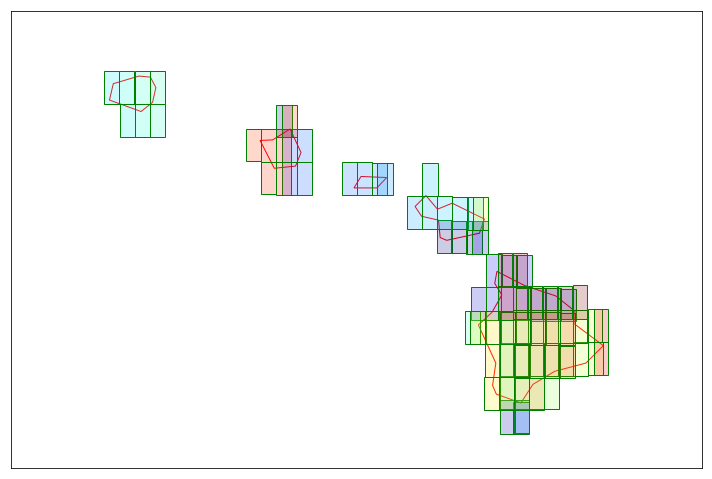

In [16]:
finer_tile_splitter = TileSplitter([hawaii_area], CRS.WGS84, ('2017-10-01', '2018-03-01'), tile_split_shape=(7, 3),
                                   data_source=DataSource.SENTINEL2_L1C, instance_id=INSTANCE_ID)

show_splitter(finer_tile_splitter, show_legend=False)